# Model 2: random forest

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading dataset and dropping the first column, because it contains rownumbers
data = pd.read_csv('data/Kickstarter_cleaned2.csv')
df = data.drop(columns=["Unnamed: 0","backers_count","id","usd_pledged","category_name",
                        "category_id","month_deadline","weekday_deadline",
                        "weekday_launched_at","country_US_True"])
df.columns

Index(['category_parent_id', 'usd_goal', 'duration_days', 'duration_days_prep',
       'year_deadline', 'winter_deadline_True', 'spring_deadline_True',
       'summer_deadline_True', 'deadline_weekend_True',
       'launched_weekend_True', 'eastcoast_True', 'long_blurb_True',
       'long_name_True', 'state_b_True', 'long_creator_name_True'],
      dtype='object')

## Model

In [3]:
# Defining X and y
y = df.state_b_True
X = df.drop(columns='state_b_True')

# Splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [4]:
# Define columns to scale
col_scale = ['category_parent_id','usd_goal', 'duration_days','duration_days_prep',
             'year_deadline']

# Scale columns
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale])
X_test_scaled = scaler.transform(X_test[col_scale])

# Concatenating scaled and dummy columns 
X_train_preprocessed = np.concatenate([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
X_test_preprocessed = np.concatenate([X_test_scaled, X_test.drop(col_scale, axis=1)], axis=1)

In [5]:
# Features for feature importances
features = ['category_parent_id', 'usd_goal', 'duration_days', 'duration_days_prep',
            'year_deadline', 'winter_deadline_True', 'spring_deadline_True',
            'summer_deadline_True', 'deadline_weekend_True',
            'launched_weekend_True', 'eastcoast_True', 'long_blurb_True','long_name_True',
            'long_creator_name_True']

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=50, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(X_train_preprocessed, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=50,
                       verbose=1)

## Results

In [6]:
# Get the average number of nodes and the depth
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 62693
Average maximum depth 38


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


Recall Test: 0.79
Precision Test: 0.72
Roc Test: 0.79


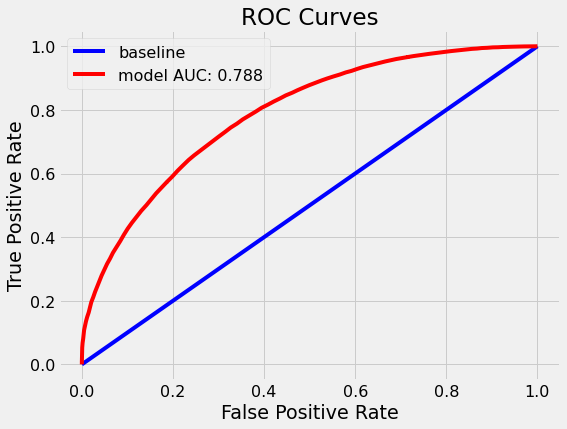

<Figure size 432x288 with 0 Axes>

In [7]:
# Testing predictions (to determine performance)
rf_predictions = model.predict(X_test_preprocessed)
rf_probs = model.predict_proba(X_test_preprocessed)[:, 1]

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(rf_predictions, rf_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    results = {}
    
    results['recall'] = recall_score(y_test, rf_predictions)
    results['precision'] = precision_score(y_test, rf_predictions)
    results['roc'] = roc_auc_score(y_test, rf_probs)
     
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Test: {round(results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, rf_probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline');
    plt.plot(model_fpr, model_tpr, 'r', label = 'model AUC: %.3f'%results['roc']);
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(rf_predictions, rf_probs)
plt.savefig('roc_auc_curve.png');

The **ROC curve** of the random forest model is closer to 1 than the ROC curve of the logistic regression model. Consequently, the **AUC** is much higher and thus better.

Confusion matrix, without normalization
[[13602  8410]
 [ 5709 22137]]


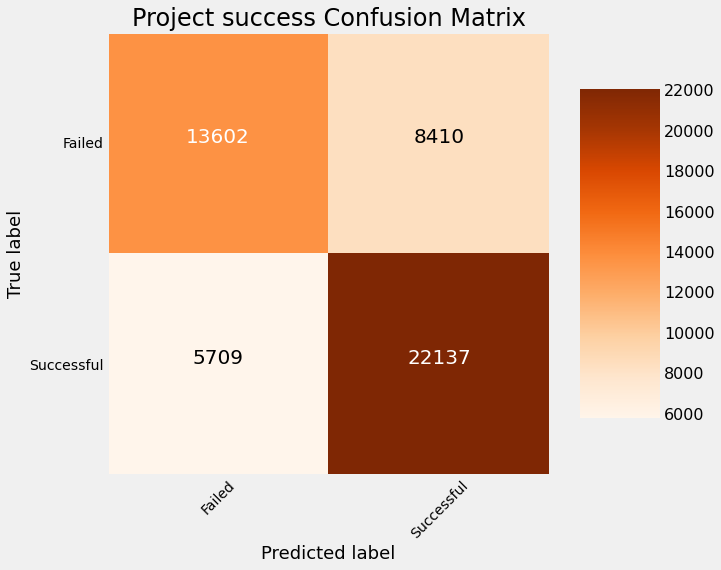

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm, classes = ['Failed', 'Successful'],
                      title = 'Project success Confusion Matrix')

The **confusion matrix** shows that our random forest model is:

* still good at predicting that a project was successful when it was successful
* better at predicting that a project failed when it failed.